# Credit Card Routing for Online Purchase via Predictive Modelling

Importing basic libraries

In [406]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

Reading the raw data

In [410]:
df = pd.read_excel(r"PSP_Jan_Feb_2019.xlsx")

Checking the datatypes of the columns and making sure that it matches our expectation

In [411]:
df.dtypes

Unnamed: 0             int64
tmsp          datetime64[ns]
country               object
amount                 int64
success                int64
PSP                   object
3D_secured             int64
card                  object
dtype: object

Checking if there is any null cells

In [413]:
df.isna().sum()

Unnamed: 0    0
tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

Checking if there is any logical errors like having any illogical values in specific columns

In [414]:
df[df['3D_secured']>=2].sum()

Unnamed: 0    0.0
country       0.0
amount        0.0
success       0.0
PSP           0.0
3D_secured    0.0
card          0.0
dtype: float64

In [415]:
df["Attempt"] = 1

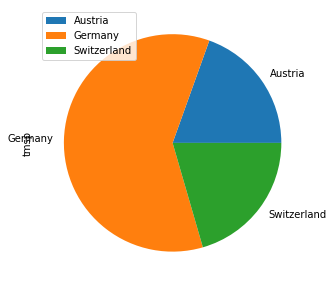

In [416]:
piv = pd.pivot_table(df, values='tmsp', index=['country'], aggfunc='count')
piv

plot = piv.plot.pie(y='tmsp', figsize=(5, 5))

Calculating the attempt number for each try

In [417]:
for index, row in df.iterrows():    
    if ((row['tmsp'] >= (df.iat[index-1,1]- timedelta(minutes=1)))&(row['country'] == df.iat[index-1,2])&(row['amount'] == df.iat[index-1,3])):
        df.iat[index,8] = df.iat[index-1,8]+1


After adding it our raw data would look like shown in below block

In [418]:
df

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card,Attempt
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,1
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,1
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1
...,...,...,...,...,...,...,...,...,...
50405,50405,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa,2
50406,50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master,1
50407,50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master,2
50408,50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master,3


Making copy of the dataframe and processing the dataset.

In [419]:
raw = df.copy()

In [420]:
raw = raw.drop(columns=["Unnamed: 0"])

In [421]:
target = raw.success
# inputs = raw.drop(columns=["success"])
inputs = raw
dummies_Country = pd.get_dummies(inputs.country)
dummies_PSP = pd.get_dummies(inputs.PSP)
dummies_card = pd.get_dummies(inputs.card)
inputs['hour'] = inputs.tmsp.apply(lambda x: x.hour)
inputs['minute'] = inputs.tmsp.apply(lambda x: x.minute)
inputs = inputs.drop(columns=['tmsp'])

In [422]:
inputs = pd.concat([inputs, dummies_Country, dummies_PSP, dummies_card], axis='columns')

In [423]:
inputs = inputs.drop(columns = ['country', 'PSP', 'card'])

In [424]:
inputs

,amount,success,3D_secured,Attempt,hour,minute,Austria,Germany,Switzerland,Goldcard,Moneycard,Simplecard,UK_Card,Diners,Master,Visa
0,89,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1
1,89,1,0,2,0,1,0,1,0,0,0,0,1,0,0,1
2,238,0,1,1,0,2,0,1,0,0,0,0,1,1,0,0
3,238,1,1,2,0,3,0,1,0,0,0,0,1,1,0,0
4,124,0,0,1,0,4,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50405,415,0,0,2,23,45,0,0,1,0,0,0,1,0,0,1
50406,91,0,0,1,23,46,1,0,0,0,0,0,1,0,1,0
50407,91,0,0,2,23,47,1,0,0,0,0,0,1,0,1,0
50408,91,0,0,3,23,47,1,0,0,0,0,0,1,0,1,0


### Splitting the dataset into test and train

In [426]:
succee = inputs[inputs['success']==1]
fai = inputs[inputs['success']==0]


In [427]:
succee_inputs = succee.drop(columns=["success"])
succee_target = succee.success

fai_inputs = fai.drop(columns=["success"])
fai_target = fai.success

In [428]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(succee_inputs, succee_target, test_size=0.2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(fai_inputs, fai_target, test_size=0.2)
X_train = X_train1.append(X_train2, ignore_index=True)
X_test = X_test1.append(X_test2, ignore_index=True)
y_train = y_train1.append(y_train2, ignore_index=True)
y_test = y_test1.append(y_test2, ignore_index=True)

In [429]:
len(X_train)

40327

In [431]:
len(X_test)

10083

### Building predictive model with Naive Bayes

In [432]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
model = GaussianNB()
model.fit(X_train,y_train)

GaussianNB()

Testing and scoring the Accuracy of the model

In [436]:
model.score(X_test,y_test)*100

78.65714569076664

In [437]:
pred = model.predict(X_test)

In [438]:
from collections import Counter
print(Counter(pred).keys() )
print(Counter(pred).values() )

dict_keys([0, 1])
dict_values([9447, 636])


Preparing the input for GUI

In [440]:
amount = 100
D_secured = 0
Attempt = 1
hour = 6
minute = 12
Austria = 1
Germany = 0
Switzerland = 0
Master = 0
Visa = 0
Diners = 1


print('Goldcard :', model.predict([[amount,D_secured,Attempt,hour,minute,Austria,Germany,Switzerland,1,0,0,0,Master,Visa,Diners]]))
print('Goldcard Prob : ',model.predict_proba([[amount,D_secured,Attempt,hour,minute,Austria,Germany,Switzerland,1,0,0,0,Master,Visa,Diners]]))

print('Moneycard :',model.predict([[amount,D_secured,Attempt,hour,minute,Austria,Germany,Switzerland,0,1,0,0,Master,Visa,Diners]]))
print('Moneycard Prob : ',model.predict_proba([[amount,D_secured,Attempt,hour,minute,Austria,Germany,Switzerland,0,1,0,0,Master,Visa,Diners]]))

print('Simplecard :',model.predict([[amount,D_secured,Attempt,hour,minute,Austria,Germany,Switzerland,0,0,1,0,Master,Visa,Diners]]))
print('Simplecard Prob : ',model.predict_proba([[amount,D_secured,Attempt,hour,minute,Austria,Germany,Switzerland,0,0,1,0,Master,Visa,Diners]]))

print('UK_card :',model.predict([[amount,D_secured,Attempt,hour,minute,Austria,Germany,Switzerland,0,0,0,1,Master,Visa,Diners]]))
print('UK_card Prob : ',model.predict_proba([[amount,D_secured,Attempt,hour,minute,Austria,Germany,Switzerland,0,0,0,1,Master,Visa,Diners]]))

# deploy

Goldcard : [1]
Goldcard Prob :  [[0.00615021 0.99384979]]
Moneycard : [0]
Moneycard Prob :  [[0.76866079 0.23133921]]
Simplecard : [0]
Simplecard Prob :  [[0.89965808 0.10034192]]
UK_card : [0]
UK_card Prob :  [[0.83402628 0.16597372]]


## Making a recommendation PSP from the model

In [441]:
success = pd.DataFrame(columns = ["Goldcard", "Moneycard", "Simplecard","UK_card"])
probability = pd.DataFrame(columns = ["Goldcard", "Moneycard", "Simplecard","UK_card"])

for i in range(3):
    G = model.predict([[amount,D_secured,i+1,hour,minute,Austria,Germany,Switzerland,1,0,0,0,Master,Visa,Diners]])
    M = model.predict([[amount,D_secured,i+1,hour,minute,Austria,Germany,Switzerland,0,1,0,0,Master,Visa,Diners]])
    S = model.predict([[amount,D_secured,i+1,hour,minute,Austria,Germany,Switzerland,0,0,1,0,Master,Visa,Diners]])
    U = model.predict([[amount,D_secured,i+1,hour,minute,Austria,Germany,Switzerland,0,0,0,1,Master,Visa,Diners]])
    G_p = model.predict_proba([[amount,D_secured,i+1,hour,minute,Austria,Germany,Switzerland,1,0,0,0,Master,Visa,Diners]])
    M_p = model.predict_proba([[amount,D_secured,i+1,hour,minute,Austria,Germany,Switzerland,0,1,0,0,Master,Visa,Diners]])
    S_p = model.predict_proba([[amount,D_secured,i+1,hour,minute,Austria,Germany,Switzerland,0,0,1,0,Master,Visa,Diners]])
    U_p = model.predict_proba([[amount,D_secured,i+1,hour,minute,Austria,Germany,Switzerland,0,0,0,1,Master,Visa,Diners]])
    
    if i==0:
        success = success.append({'Goldcard': G[0], 'Moneycard': M[0], 'Simplecard': S[0], 'UK_card': U[0]}, ignore_index=True)
        probability = probability.append({'Goldcard': G_p[0][1], 'Moneycard': M_p[0][1], 'Simplecard': S_p[0][1], 'UK_card': U_p[0][1]}, ignore_index=True)
    else:
        if (success['Goldcard'][i-1] == 1) | (success['Goldcard'][i-1] == 'N'):
            G = 'N'
        if (success['Moneycard'][i-1] == 1) | (success['Moneycard'][i-1] == 'N'):
            M = 'N'
        if (success['Simplecard'][i-1] == 1) | (success['Simplecard'][i-1] == 'N'):
            S = 'N'
        if (success['UK_card'][i-1] == 1) | (success['UK_card'][i-1] == 'N'):
            U = 'N'
            
        success = success.append({'Goldcard': G[0], 'Moneycard': M[0], 'Simplecard': S[0], 'UK_card': U[0]}, ignore_index=True)
        probability = probability.append({'Goldcard': G_p[0][1], 'Moneycard': M_p[0][1], 'Simplecard': S_p[0][1], 'UK_card': U_p[0][1]}, ignore_index=True)

        
    
    
price = success.replace(to_replace ='N' , value =np.nan)
price['Goldcard'] = price['Goldcard'].replace(to_replace = 1 , value = 10)
price['Goldcard'] = price['Goldcard'].replace(to_replace = 0 , value = 5)

price['Moneycard'] = price['Moneycard'].replace(to_replace = 1 , value = 5)
price['Moneycard'] = price['Moneycard'].replace(to_replace = 0 , value = 2)

price['Simplecard'] = price['Simplecard'].replace(to_replace = 1 , value = 1)
price['Simplecard'] = price['Simplecard'].replace(to_replace = 0 , value = 0.5)

price['UK_card'] = price['UK_card'].replace(to_replace = 1 , value = 3)
price['UK_card'] = price['UK_card'].replace(to_replace = 0 , value = 1)


total_cost = price.sum()

expense = total_cost.to_frame()
expense = expense.reset_index()
expense['Success/Not'] = True


for index, row in expense.iterrows(): 
    expense.iat[index,2] = (success[row['index']].isin([1]).any())    
    


expense = expense.rename(columns={"index": "PSP", 0: "Total cost", "Success/Not": "Success/Not"}, errors="raise")

expense = expense[expense['Success/Not'] == True]

expense = expense.sort_values(by=['Total cost'])

if expense.shape[0]==0:
    print('PSP recommended :','Simplecard')
else:
    print('PSP recommended :', expense['PSP'][0])



PSP recommended : Goldcard


Building other predictive models using different methods to see if any other methods got better accuracy

In [442]:
from sklearn.metrics import accuracy_score
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# Evaluate model performance
print(accuracy_score(y_train, y_train_pred))

print(accuracy_score(y_test, y_test_pred))


0.7848091849133335
0.7865714569076664


In [443]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,random_state=1)

bag.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.8,
                  n_estimators=100, random_state=1)

In [444]:
bag.score(X_test,y_test)*100

78.4092036100367

In [445]:
from sklearn.ensemble import RandomForestClassifier

ran = RandomForestClassifier(n_estimators=100, random_state=0)
ran.fit(X_train,y_train)
ran.score(X_test,y_test)*100

78.19101457899434

In [447]:
from sklearn import linear_model

ran = linear_model.LinearRegression()
ran.fit(X_train,y_train)
ran.score(X_test,y_test)*100

3.850714168059466

With this we can see our Naive Bayes model got better scores than the rest